# Harris Corner Detection

In [29]:
from skimage import data, io, filters, color
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import cv2 as cv

## Gaussian Smooth

In [30]:
def gaussian_kernel(window_size, sigma):
    N = (window_size + 1) // 2

    rhalf_kernel = np.zeros((N,))
    
    for i in range(N):
        x_n = i / sigma
        rhalf_kernel[i] = np.exp(-0.5 * x_n * x_n)

    if window_size % 2 == 0:
        lhalf_kernel = np.flip(rhalf_kernel)
    else:
        lhalf_kernel = np.flip(rhalf_kernel[1:])
        
    kernel = np.concatenate([lhalf_kernel, rhalf_kernel])
    
    kernel /= sum(kernel)
    
    return kernel

In [31]:
def gaussian_smooth(image, k, sigma):
    kernel = cv.getGaussianKernel(k, sigma)
    kernel = kernel @ kernel.T
    
    img = np.zeros(image.shape)
    
    for i in range(3):
        img[:,:,i] = sp.signal.convolve2d(image[:,:,i], kernel, mode='same')
        img[:,:,i] /= np.max(img[:,:,i])
    
    return img

## Sobel Edge Detection

In [4]:
def sobel_edge_detection(image):
    image = color.rgb2gray(image)
    avg = np.array([1, 2, 1])
    diff = np.array([1, 0, -1])

    m, n = image.shape[:2]
    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)

    for i in range(m):
        gx[i,:] = np.convolve(image[i,:], diff, mode='same')
        gy[i,:] = np.convolve(image[i,:], avg, mode='same')

    for i in range(n):
        gx[:,i] = np.convolve(gx[:,i], avg, mode='same')
        gy[:,i] = np.convolve(gy[:,i], diff, mode='same')

    mag_img = np.sqrt(gx**2 + gy**2)
    mag_img = np.floor(mag_img * 255.0 / np.max(mag_img))

    gx += np.ones(gx.shape) * 0.00001
    dir_img = np.arctan(gy / gx)
    
    return [mag_img, dir_img]

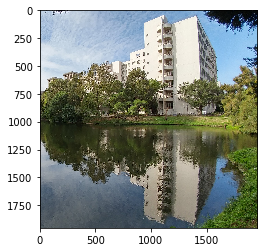

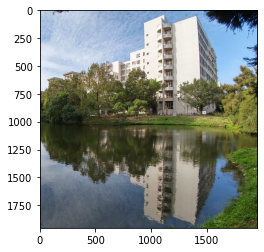

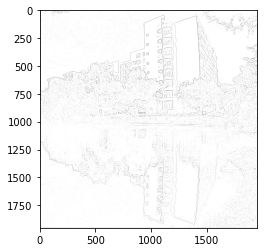

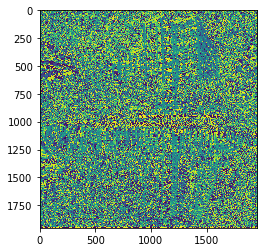

In [10]:
image = plt.imread('original.jpg')

plt.figure()
plt.imshow(image)

smooth_img = gaussian_smooth(image, 11, 5)

plt.figure()
plt.imshow(smooth_img)

sed_img = sobel_edge_detection(smooth_img)
plt.figure()
plt.imshow(sed_img[0], cmap='binary')

plt.figure()
plt.imshow(sed_img[1])

plt.show()

## Structure Tensor

In [32]:
def structure_tensor(img, size):
    img = color.rgb2gray(img)

    # Sobel operator
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    gx = sp.signal.convolve2d(img, kernel_x, mode='same')
    gy = sp.signal.convolve2d(img, kernel_y, mode='same')

    # Compute structure tensor using convolution
    window = np.ones((size, size))

    Ixx = sp.signal.convolve2d(gx * gx, window, mode='same')
    Iyy = sp.signal.convolve2d(gy * gy, window, mode='same')
    Ixy = sp.signal.convolve2d(gx * gy, window, mode='same')

    det = Ixx * Iyy - Ixy**2
    trace = Ixx + Iyy

    # Response function
    R = det - 0.04 * trace * trace
    m, n = img.shape[:]
    out_img = np.zeros(img.shape)
    
    for i in range(m):
        for j in range(n):
            if R[i,j] > 0:
                out_img[i,j] = 255
    return out_img

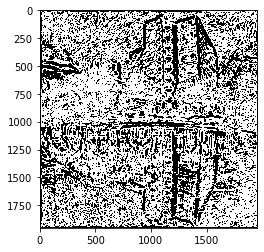

In [35]:
img = plt.imread('original.jpg')
cr_img = structure_tensor(gaussian_smooth(img, 21, 7), 10)

plt.figure()
plt.imshow(cr_img, cmap='gray')
plt.show()